# Loss comparison (DA vs. weighted particles)
Given a regular radial scan performed with Sixtrack, we try different distributions and compare the lost amount of beam.

## Set correct working directory
(since SWAN generates a new instance of the notebook in another empty directory)

In [ ]:
cd /eos/project/d/da-and-diffusion-studies/DA_Studies/Simulations/Models/da_sixtrack

## Import libraries

In [1]:
%matplotlib notebook

In [2]:
# Base libraries
import math
import numpy as np
import scipy.integrate as integrate
from scipy.special import erf
import pickle
import itertools

from numba import njit, prange

# Personal libraries
import sixtrackwrap_light as sx

import time
import matplotlib.pyplot as plt
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from math import gcd

# For this "presentation" only! As some plotting parts execute a np.log10(0)
import warnings
warnings.filterwarnings('ignore')


## Load data and setup

In [3]:
savepath = "data/"
engine = sx.radial_scanner.load_values(savepath + "big_scan.pkl")

min_turns = engine.min_time
max_turns = engine.max_time
n_turn_samples = 50

turn_sampling = np.linspace(min_turns, max_turns, n_turn_samples, dtype=np.int_)[::-1]

d_r = engine.dr
starting_step = engine.starting_step

# BASELINE COMPUTING
baseline_samples = 33
baseline_total_samples = baseline_samples ** 3

In [4]:
alpha_preliminary_values = np.linspace(-1.0, 1.0, baseline_samples)
alpha_values = np.arccos(alpha_preliminary_values) / 2
theta1_values = np.linspace(0.0, np.pi * 2.0, baseline_samples, endpoint=False)
theta2_values = np.linspace(0.0, np.pi * 2.0, baseline_samples, endpoint=False)

d_preliminar_alpha = alpha_preliminary_values[1] - alpha_preliminary_values[0]
d_theta1 = theta1_values[1] - theta1_values[0]
d_theta2 = theta2_values[1] - theta2_values[0]

alpha_mesh, theta1_mesh, theta2_mesh = np.meshgrid(alpha_values, theta1_values, theta2_values, indexing='ij')

alpha_flat = alpha_mesh.flatten()
theta1_flat = theta1_mesh.flatten()
theta2_flat = theta2_mesh.flatten()

## A Colormap for roughly visualize all the samples

<IPython.core.display.Javascript object>


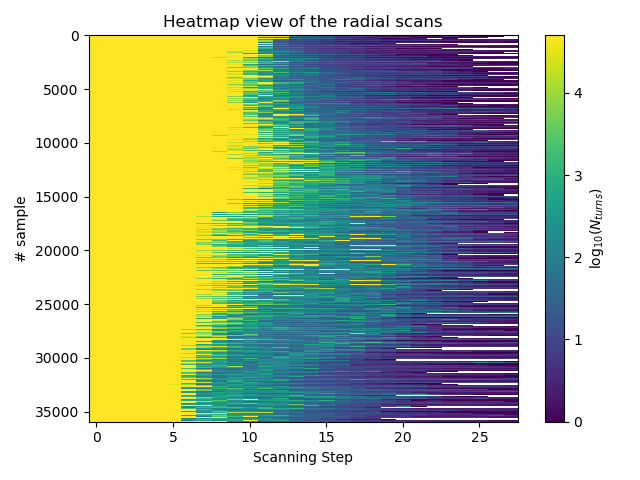

In [18]:
fig1, ax1 = plt.subplots()
cmap = ax1.imshow(np.log10(engine.steps), aspect="auto")
ax1.set_ylabel("# sample")
ax1.set_xlabel("Scanning Step")
cbar = plt.colorbar(cmap)
cbar.ax.set_ylabel("$\\log_{10}(N_{turns})$")
ax1.set_title("Heatmap view of the radial scans")
plt.tight_layout()

## Exploring and visualizing 3D samples of DA!

With this tool, you can (somewhat) visualize the angular dependencies of DA by moving the $\theta_1$ and $\theta_2$ sliders and setting up 3D samples of different dimension (the resulting sample is sample_size ** 3 big).

What you will then visualize is the evolution of DA with the number of turns, considering different $\alpha$ angles ($\alpha$ indicates the central angle of the considered sample).

**N.B.: the plotting process requires time, so after moving the sliders you will need to wait a little!**

<IPython.core.display.Javascript object>


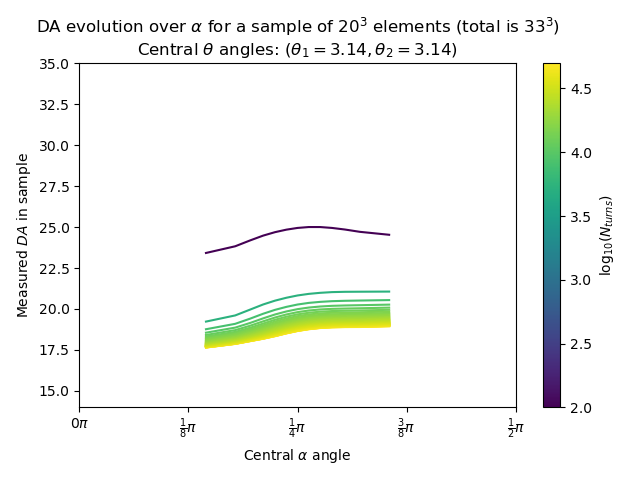

interactive(children=(IntSlider(value=14, description='sample_size', max=29, min=2, step=2), FloatSlider(value…

In [6]:
fig, ax = plt.subplots()
cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=np.log10(turn_sampling[-1]), vmax=np.log10(turn_sampling[0]))
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), label='$\\log_{10}(N_{turns})$')

radiuses = engine.extract_DA(turn_sampling)
radiuses = radiuses.reshape((baseline_samples, baseline_samples, baseline_samples, len(turn_sampling)))

@njit
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

@njit
def take_sample(array, value, size):
    assert size % 2 == 0
    array = np.asarray(array)
    idx = find_nearest(array, value)
    if idx < size:
        return 0, size
    elif idx >= len(array) - size:
        return len(array) - size, len(array)
    else:
        return idx - size // 2, idx + size // 2

@widgets.interact(sample_size=(2, baseline_samples - 4, 2), th1=(0, 2*np.pi+0.01, 0.01), th2=(0, 2*np.pi+0.01, 0.01))
def update1(sample_size, th1, th2):
    y_values = np.empty((len(range(sample_size, len(alpha_preliminary_values))), len(turn_sampling)))
    x_values = np.empty((len(range(sample_size, len(alpha_preliminary_values)))))
    for i, a_max in enumerate(range(sample_size, len(alpha_preliminary_values))):
        a_min = a_max - sample_size
        
        th1_min, th1_max = take_sample(theta1_values, th1, sample_size)
        th2_min, th2_max = take_sample(theta2_values, th2, sample_size)
        alpha_sample = alpha_preliminary_values[a_min : a_max]
        theta1_sample = theta1_values[th1_min : th1_max]
        theta2_sample = theta1_values[th2_min : th2_max]

        a_mid = (alpha_values[a_min] + alpha_values[a_max]) / 2
        
        mod_radiuses = np.power(radiuses, 4)[a_min : a_max, th1_min : th1_max, th2_min : th2_max]
        
        mod_radiuses = integrate.simps(mod_radiuses, x=theta1_sample, axis=1)
        mod_radiuses = integrate.simps(mod_radiuses, x=theta2_sample, axis=1)
        mod_radiuses = integrate.simps(mod_radiuses, x=alpha_sample, axis=0)

        DA = (
            np.power(
                mod_radiuses / (
                    (alpha_sample[-1] - alpha_sample[0]) 
                    * (theta1_sample[-1] - theta1_sample[0]) 
                    * (theta2_sample[-1] - theta2_sample[0])),
                1/4
            )
        )
        y_values[i] = DA
        x_values[i] = a_mid
    y_values = np.asarray(y_values)
    y_values = y_values.transpose()
    x_values = np.asarray(x_values)
    ax.clear()
    for i in range(y_values.shape[0]):
        value = np.log10(turn_sampling[i] - turn_sampling[-1]) / np.log10(turn_sampling[0] - turn_sampling[-1])
        ax.plot(x_values, y_values[i], c=cmap(value))
    ax.set_xlabel("Central $\\alpha$ angle")
    ax.set_ylabel("Measured $DA$ in sample")
    ax.set_title("DA evolution over $\\alpha$ for a sample of ${}^3$ elements (total is ${}^3$)\nCentral $\\theta$ angles: $(\\theta_1 = {:.2f}, \\theta_2 = {:.2f})$".format(sample_size, baseline_samples, th1, th2, baseline_samples))
    ax.set_ylim(np.min(radiuses), np.max(radiuses))
    ax.set_xlim(0.0, np.pi / 2.0)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(
            lambda x, pos: ("$\\frac{{{}}}{{{}}}$".format(int(x/(np.pi/8)) // gcd(8, int(x/(np.pi/8))), 8 // gcd(8, int(x/(np.pi/8)))) if x != 0 else "0") + "$\\pi$"
        )
    )
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=np.pi/8))
    plt.tight_layout()


# Setup for loss comparison analysis

In [7]:
radiuses = engine.extract_DA(turn_sampling)
radiuses = radiuses.reshape((baseline_samples, baseline_samples, baseline_samples, len(turn_sampling)))

In [8]:
DA = []

mod_radiuses = radiuses.copy()
mod_radiuses = np.power(radiuses, 4)
mod_radiuses1 = integrate.simps(mod_radiuses, x=theta1_values, axis=1)
mod_radiuses2 = integrate.simps(mod_radiuses1, x=theta2_values, axis=1)
mod_radiuses3 = integrate.simps(mod_radiuses2, x=alpha_preliminary_values, axis=0)

for i in range(len(turn_sampling)):
    DA.append(
        np.power(
            mod_radiuses3[i] / (2 * theta1_values[-1] * theta2_values[-1]),
            1/4
        )
    )

DA = np.asarray(DA)

In [9]:
axis_sampling = np.concatenate((turn_sampling,[0.0]))

# How is the error on the DA loss computed right now?

1. Consider all the radiuses sampled.
2. Compute the DA value.
3. For every radius sampled, compute the difference from the DA value.
4. The absolute value of the average of all these differences is considered as error.

(I tried using the Standard Deviation of the radiuses distribution, but it ended up being 10% of the DA itself, so we "need" somehow a smaller error estimation)

# Uniform distribution case
Just as a test... nothing extreme to see here.

Maybe this can be a testbench for the error measure?

In [10]:
def loss_from_DA(da_list, da_cut):
    temp = np.pi ** 2 / 2 * np.power(da_list, 4)
    return np.concatenate((temp, [np.pi ** 2 / 2 * np.power(da_cut, 4)]))

values = loss_from_DA(DA, 26.0)
values /= values[-1]
values[-20:]

# Error computing

values1 = loss_from_DA(DA - np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), 26)
values1 /= values1[-1]

values2 = loss_from_DA(DA + np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), 26)
values2 /= values2[-1]

In [11]:
engine.assign_weights(
    sx.assign_uniform_distribution()
)

<IPython.core.display.Javascript object>


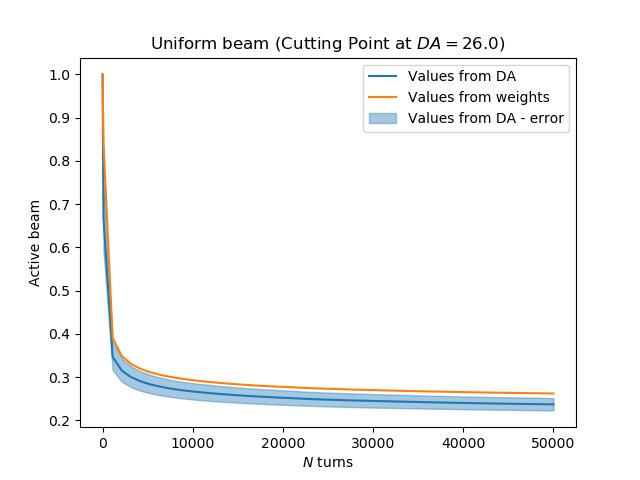

Text(0.5, 1.0, 'Uniform beam (Cutting Point at $DA=26.0$)')

In [12]:
real_values = engine.compute_loss(turn_sampling, 26)
real_values
fig3, ax3 = plt.subplots()
ax3.plot(axis_sampling, values, label="Values from DA")
ax3.fill_between(axis_sampling, values1, values2, label="Values from DA - error", color="C0", alpha=0.4)
ax3.plot(axis_sampling, real_values, label="Values from weights")
ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("Active beam")
ax3.set_title("Uniform beam (Cutting Point at $DA=26.0$)")

# Gaussian with slider available for $\sigma$

With the slider it is possible to regulate the $\sigma$ value of the 4D gaussian beam distribution.

It is possible to observe how extreme values for $\sigma$ strongly changes the two loss behaviours.

**N.B.: Place the slider at the desired position and then wait for the automatic refresh!**

<IPython.core.display.Javascript object>


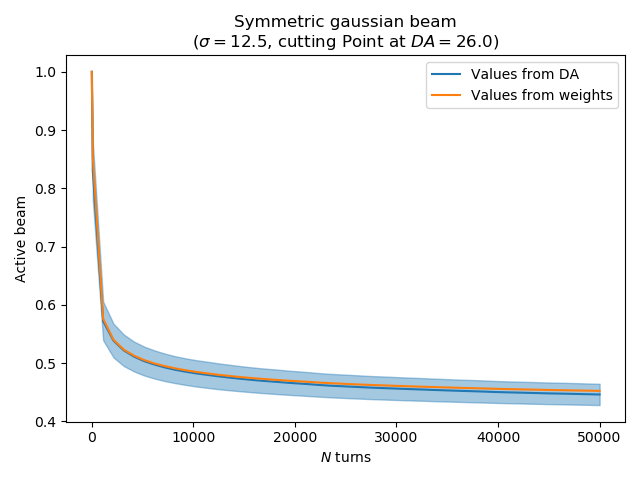

interactive(children=(FloatSlider(value=15.0, description='sigma', max=30.0, min=1.0, step=0.5), Output()), _d…

In [13]:
fig2, ax2 = plt.subplots()

@widgets.interact(sigma=(1,30,0.5))
def update2(sigma):
    ax2.clear()
    # Cursed Sanity Check
    def loss_from_DA(DA_list, DA_max):
        temp = - np.exp(- ((DA_list / sigma) ** 2) / 2) * (DA_list ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2
        return np.concatenate((temp, [- np.exp(- ((DA_max / sigma) ** 2) / 2) * (DA_max ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2]))

    values = loss_from_DA(DA, 26.0)
    values /= values[-1]
    values[-20:]

    # Error computing
    
    values1 = loss_from_DA(DA - np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), 26)
    values1 /= values1[-1]

    values2 = loss_from_DA(DA + np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), 26)
    values2 /= values2[-1]

    engine.assign_weights(
        sx.assign_symmetric_gaussian(sigma)
    )

    real_values = engine.compute_loss(turn_sampling, 26)
    real_values
    ax2.plot(axis_sampling, values, label="Values from DA")
    ax2.fill_between(axis_sampling, values1, values2, color="C0", alpha=0.4)
    ax2.plot(axis_sampling, real_values, label="Values from weights")
    ax2.legend()
    ax2.set_xlabel("$N$ turns")
    ax2.set_ylabel("Active beam")
    ax2.set_title("Symmetric gaussian beam\n($\\sigma = {}$, cutting Point at $DA=26.0$)".format(sigma))
    plt.tight_layout()


# From this point... there is legacy stuff and work in progress

# Gaussian distribution --- Legacy stuff
## Simple Gaussian -- high sigma

In [39]:
sigma = 17.5

# Cursed Sanity Check
def loss_from_DA(DA_list, DA_max):
    temp = - np.exp(- ((DA_list / sigma) ** 2) / 2) * (DA_list ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2
    return np.concatenate((temp, [- np.exp(- ((DA_max / sigma) ** 2) / 2) * (DA_max ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2]))

values = loss_from_DA(DA, 26.0)
values /= values[-1]
values[-20:]

values1 = loss_from_DA(DA - np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), 26)
values1 /= values1[-1]

values2 = loss_from_DA(DA + np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), 26)
values2 /= values2[-1]

In [40]:
engine.assign_weights(
    sx.assign_symmetric_gaussian(sigma)
)

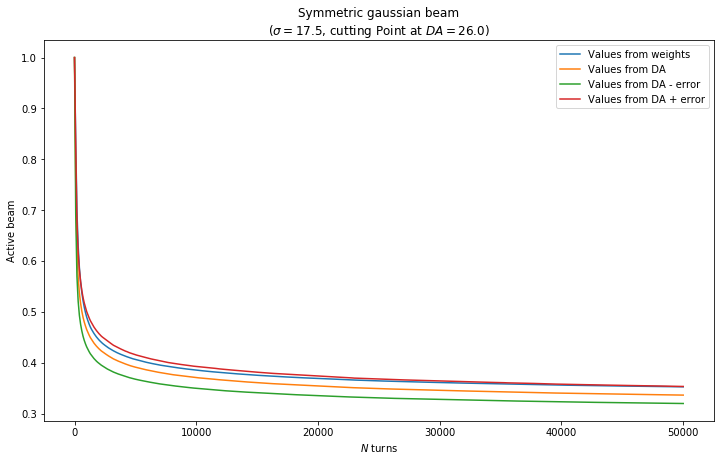

In [41]:
real_values = engine.compute_loss(turn_sampling, 26)
real_values
plt.plot(axis_sampling, real_values, label="Values from weights")
plt.plot(axis_sampling, values, label="Values from DA")
plt.plot(axis_sampling, values1, label="Values from DA - error")
plt.plot(axis_sampling, values2, label="Values from DA + error")
plt.legend()
plt.xlabel("$N$ turns")
plt.ylabel("Active beam")
plt.title("Symmetric gaussian beam\n($\\sigma = {}$, cutting Point at $DA=26.0$)".format(sigma))
plt.savefig("high_sigma_loss.jpg", dpi=600)

## Simple Gaussian -- low sigma

In [60]:
sigma = 11.0

# Sanity Check
def loss_from_DA(DA_list, DA_max):
    temp = - np.exp(- ((DA_list / sigma) ** 2) / 2) * (DA_list ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2
    return np.concatenate((temp, [- np.exp(- ((DA_max / sigma) ** 2) / 2) * (DA_max ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2]))

values = loss_from_DA(DA, 26.0)
values /= values[-1]
values[-20:]

values1 = loss_from_DA(DA - np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), 26)
values1 /= values1[-1]

values2 = loss_from_DA(DA + np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), 26)
values2 /= values2[-1]

In [61]:
engine.assign_weights(
    sx.assign_symmetric_gaussian(sigma)
)

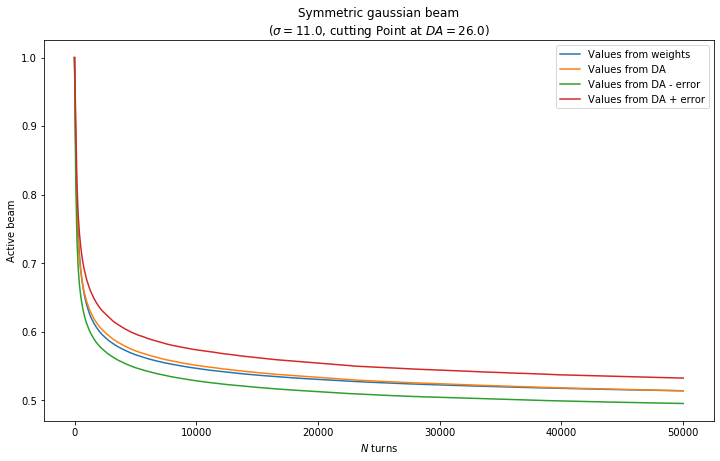

In [62]:
real_values = engine.compute_loss(turn_sampling, 26)
real_values
plt.plot(axis_sampling, real_values, label="Values from weights")
plt.plot(axis_sampling, values, label="Values from DA")
plt.plot(axis_sampling, values1, label="Values from DA - error")
plt.plot(axis_sampling, values2, label="Values from DA + error")
plt.legend()
plt.xlabel("$N$ turns")
plt.ylabel("Active beam")
plt.title("Symmetric gaussian beam\n($\\sigma = {}$, cutting Point at $DA=26.0$)".format(sigma))
plt.savefig("low_sigma_loss.jpg", dpi=600)

# Not-so-simple Gaussian (WORK IN PROGRESS!)

In [ ]:
from numba import njit
from scipy.stats import multivariate_normal
import scipy.integrate as integrate
from scipy.special import erf

sigma_x = 10.0
sigma_px = 20.0
sigma_y = 10.0
sigma_py = 20.0

func = multivariate_normal(
    [0.0, 0.0, 0.0, 0.0],
    [[sigma_x, 0.0, 0.0, 0.0],
     [0.0, sigma_px, 0.0, 0.0],
     [0.0, 0.0, sigma_y, 0.0],
     [0.0, 0.0, 0.0, sigma_py]])

def func_all(x, px, y, py, DA):
    return func.pdf([x, px, y, py]) #/ (r ** 3 * np.sin(a) * np.cos(a))

func_np = np.vectorize(func_all)

@njit
def lim_py(DA):
    return [0.0, DA]

@njit
def lim_y(py, DA):
    return [0.0, np.sqrt(DA ** 2 - py ** 2)]

@njit
def lim_px(y, py, DA):
    return [0.0, np.sqrt(DA ** 2 - y ** 2 - py ** 2)]

@njit
def lim_x(px, y, py, DA):
    return [0.0, np.sqrt(DA ** 2 - px ** 2 - y ** 2 - py ** 2)]

# Sanity Check
def loss_from_DA(DA_list, DA_max):
    temp = np.array([integrate.nquad(
        func_np,
        [lim_x, lim_px, lim_y, lim_py],
        args=(DA, ),
        opts={"epsabs":1, "epsrel":1}
        ) for DA in tqdm(DA_list)])
    return np.concatenate(
        (temp, 
         [integrate.nquad(
            func_np,
            [lim_x, lim_px, lim_y, lim_py],
            args=(DA_max, )
        )]))

values = loss_from_DA(DA, 26.0)
values /= values[-1]
values[-20:]

In [ ]:
from numba import njit
from scipy.stats import multivariate_normal
import scipy.integrate as integrate
from scipy.special import erf

sigma_x = 10.0
sigma_px = 10.0
sigma_y = 10.0
sigma_py = 10.0

func = multivariate_normal(
    [0.0, 0.0, 0.0, 0.0],
    [[sigma_x, 0.0, 0.0, 0.0],
     [0.0, sigma_px, 0.0, 0.0],
     [0.0, 0.0, sigma_y, 0.0],
     [0.0, 0.0, 0.0, sigma_py]])

def func_all(x, px, y, py, DA):
    return func.pdf([x, px, y, py]) #/ (r ** 3 * np.sin(a) * np.cos(a))

func_np = np.vectorize(func_all)

# Sanity Check
def loss_from_DA(DA_list, DA_max):
    temp = np.array([
        erf(DA / sigma_x) * erf(DA / sigma_px)  * erf(DA / sigma_y) * erf(DA / sigma_py)
        for DA in DA_list])
    return np.concatenate(
        (temp, 
         [erf(DA_max / sigma_x) * erf(DA_max / sigma_px)  * erf(DA_max / sigma_y) * erf(DA_max / sigma_py)]
        ))

values = loss_from_DA(DA, 26.0)
values /= values[-1]
values[-20:]

In [ ]:
@njit
def my_gaussian(x, px, y, py):
    sigma_x = 10.0
    sigma_px = 10.0
    sigma_y = 10.0
    sigma_py = 10.0
    return (
        (1.0 / (np.power(2 * np.pi, 2) * sigma_x * sigma_px * sigma_y * sigma_py))
        * np.exp(- 0.5 * (np.power(x / sigma_x, 2) + np.power(px / sigma_px, 2) + np.power(y / sigma_y, 2) + np.power(py / sigma_py, 2)))
    )

@njit(parallel=True)
def mc_extraction(n_samples, radius):
    samples = np.empty(n_samples)
    coords = np.empty((4, n_samples))
    for i in prange(n_samples):
        coord = np.random.rand(4) * radius
        while np.sum(np.power(coord, 2)) >= radius ** 2:
            coord = np.random.rand(4) * radius
        coords[:, i] = coord
    samples = my_gaussian(coords[0, :], coords[1, :], coords[2, :], coords[3, :])
    return np.mean(samples), np.mean(samples) * np.pi * np.pi * (radius ** 4) / 2, np.std(samples) * np.pi * np.pi * (radius ** 4) / 2 / np.sqrt(n_samples)

mc_extraction(500000000, 10)

In [ ]:
engine.assign_weights(
    sx.assign_generic_gaussian(sigma_x, sigma_px, sigma_y, sigma_py)
)

In [ ]:
real_values = engine.compute_loss(turn_sampling, 26)
real_values

plt.plot(axis_sampling, real_values, label="Values from weights")
plt.plot(axis_sampling, values, label="Values from DA")
plt.legend()
plt.xlabel("$N$ turns")
plt.ylabel("Active beam")
plt.title("Symmetric gaussian beam\n($\\sigma = {}$, cutting Point at $DA=26.0$)".format(sigma))

Text(0.5, 1.0, 'Symmetric gaussian beam\n($\\sigma = 10.0$, cutting Point at $DA=26.0$)')

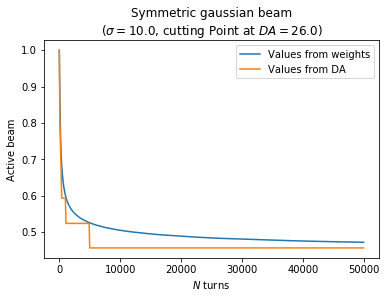

In [98]:
cut_values = np.array([engine.compute_loss_cut(cut) for cut in tqdm(np.concatenate((DA,[26.0])))])

plt.plot(axis_sampling, real_values, label="Values from weights")
plt.plot(axis_sampling, cut_values / cut_values[-1], label="Values from DA")
plt.legend()
plt.xlabel("$N$ turns")
plt.ylabel("Active beam")
plt.title("Symmetric gaussian beam\n($\\sigma = {}$, cutting Point at $DA=26.0$)".format(sigma))